# Simple Color Detection

Kevin J. Walchko, created 15 Jan 2017

---

We want to develop a simple image processing routine that will detect the a given color in an image. This idea can then be expanded to detecting a pattern of colors based off a histogram model.

## Objectives

- detect a color in an image
- detect a color model in an image
- basic understanding of blobs in computer vision

## References

- [Blob detection](https://www.learnopencv.com/blob-detection-using-opencv-python-c/)
- [Wikipedia HSV](https://en.wikipedia.org/wiki/HSL_and_HSV)
- [OpenCV Python documentation](http://docs.opencv.org/trunk/d6/d00/tutorial_py_root.html)
- [List of color spaces and their uses](https://en.wikipedia.org/wiki/List_of_color_spaces_and_their_uses)
- [Website to understand RGB and HSV colors](http://colorizer.org/)

## Setup

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
import cv2

## Color Detection

Steps:

1. Convert image from RGB to a better colorspace, here we use HSV
1. Thresholds an image between and upper lower HSV bounds
1. Uses `erode` to first remove small false positives
1. Uses `dilate` to close holes in the image blob.

Note, step 3 and 4 (erode then dialate) was alos called openning when we talked about morphological operators earlier.

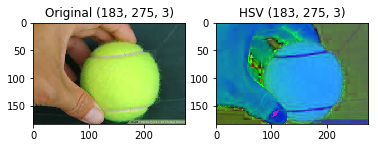

In [3]:
# read in image and convert to HSV
im = cv2.imread('tennis/tennis_test.jpg')
hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title('Original {}'.format(im.shape))

plt.subplot(1,2,2)
plt.imshow(hsv)
plt.title('HSV {}'.format(hsv.shape));

(183, 275)


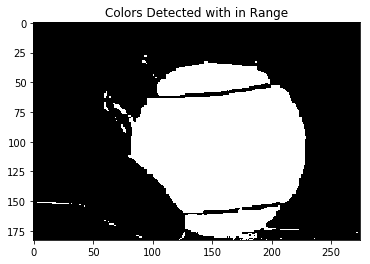

In [35]:
# find colors in ragne
greenLower = (29, 86, 6)
greenUpper = (64, 255, 255)
detect = cv2.inRange(hsv, greenLower, greenUpper)

print(detect.shape)

plt.imshow(detect, cmap='gray')
plt.title('Colors Detected with in Range');

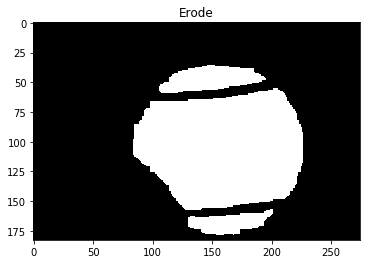

In [36]:
# get rid of stray and noisy pixels
erode = cv2.erode(mask, None, iterations=2)
plt.imshow(erode, cmap='gray')
plt.title('Erode');

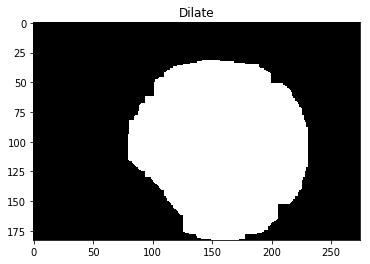

In [75]:
# close up small holes
dilate = cv2.dilate(erode, None, iterations=4)
plt.imshow(dilate, cmap='gray')
plt.title('Dilate');

Notice in the final image, there are still some detects in the lower right ... nothing is perfect and you typically still have some small left overs to clean up. So let's find things that are circular, since this is a tennis ball and should be round.

In [76]:
# search image for contours
mask = dilate
cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]

print('Found {} objects'.format(len(cnts)))

# find the largest contour in the mask, then use
# it to compute the minimum enclosing circle and
# centroid
c = max(cnts, key=cv2.contourArea)
((x, y), radius) = cv2.minEnclosingCircle(c)
x, y, radius = int(x), int(y), int(radius)
print('Circle center: ({}, {})   radius: {} pixels'.format(x, y, radius))

Found 1 objects
Circle center: (155, 106)   radius: 79 pixels


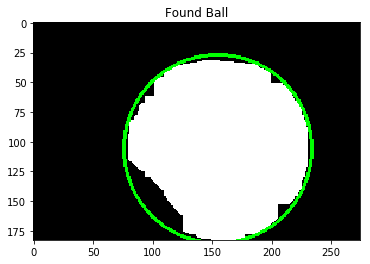

In [77]:
# now convert the image from grayscale back to color so we can
# draw colors on it ... this is only necessary for display
cmask = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)

# draw circle on image
cv2.circle(cmask,(x,y),radius,(0,255,0),2)

plt.imshow(cmask)
plt.title('Found Ball');

# Blob Detection

OpenCV has a simple blob detector built into it. However, the performance, atleast on the python side, seems to be a little finicky, so might have to play with the parameters to get them to work right.

![](blobs/blob_detection.jpg)

The steps are:

1. Convert the source image to binary images by applying thresholding with several thresholds from minThreshold (inclusive) to maxThreshold (exclusive) with distance thresholdStep between neighboring thresholds.
1. Extract connected components from every binary image by findContours and calculate their centers.
1. Group centers from several binary images by their coordinates. Close centers form one group that corresponds to one blob, which is controlled by the minDistBetweenBlobs parameter.
1. From the groups, estimate final centers of blobs and their radiuses and return as locations and sizes of keypoints.

The detector performs several filtrations of the discovered blobs. The default appears to be searching for darker (i.e., black) blobs which is the inverse of what you often think of.

<img src="blobs/BlobTest.jpg" width="400px">

Available filtrations:

- **Color** (**This seems to be broken**). This filter compares the intensity of a binary image at the center of a blob to blobColor. If they differ, the blob is filtered out. 
    - blobColor = 0 to extract dark blobs
    - blobColor = 255 to extract light blobs.
- **Area**. Extracted blobs have an area between minArea (inclusive) and maxArea (exclusive).
- **Circularity**. Extracted blobs have circularity ($\frac{4∗\pi∗Area}{perimeter^2}$) between minCircularity (inclusive) and maxCircularity (exclusive).
    - A circle has a circularity of 1
    - A regular hexagon has higher circularity than say a square
- **Ratio of the minimum inertia to maximum inertia**. All you have to know is that this measures how elongated a shape is. E.g. for a circle, this value is 1, for an ellipse it is between 0 and 1, and for a line it is 0. Extracted blobs have this ratio between minInertiaRatio (inclusive) and maxInertiaRatio (exclusive).
<img src="blobs/inertia.jpg" width="400px">
- **Convexity**. Extracted blobs have convexity ($\frac{area}{area_{blob-convex-hull}}$) between minConvexity (inclusive) and maxConvexity (exclusive).
<img src="blobs/concave-convex.jpg" width="400px">

Default values of parameters are tuned to extract dark circular blobs. This, if you calculate a mask image, usually the object of interest is white, you will need to invert the image.

```python
params = cv2.SimpleBlobDetector_Params()

# color - doesn't seem to work
# params.blobColor = 255

# Change thresholds - levels
params.minThreshold = 0  # inclusive
params.maxThreshold = 1  # exclusive
params.thresholdStep = 1

# Filter by Area.
params.filterByArea = True
params.minArea = 1500

# Filter by Circularity - doesn't seem very precise
params.filterByCircularity = True
params.maxCircularity = 1.2
params.minCircularity = .7

# Filter by Convexity
params.filterByConvexity = True
params.minConvexity = 0.87

# Filter by Inertia
params.filterByInertia = True
params.minInertiaRatio = 0.01

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(gray)
im_with_keypoints = cv2.drawKeypoints(
    frame,
    keypoints,
    None,  # output image
    (0,0,255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(im_with_keypoints)
```

[Parameters]
  Repeatability: 2
  Color[True]
  Threshold[10.0]: 50.0:100.0
  Inertia[False]: 0.10000000149/0.10000000149
  Area[False]: 25.0/5000.0
  Convexity[True]: 0.949999988079/3.40282346639e+38
  Circularity[False]: 0.800000011921/3.40282346639e+38
key points found: 1
> key point: (154.33624267578125, 124.2386474609375) 149.556365967


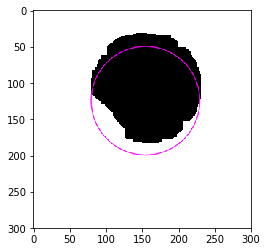

In [82]:
def printParams(params):
    print('[Parameters]')
    print('  Repeatability: {}'.format(params.minRepeatability))
    print('  Color[{}]'.format(params.filterByColor))
    print('  Threshold[{}]: {}:{}'.format(
        params.thresholdStep, 
        params.minThreshold, 
        params.maxThreshold))
    print('  Inertia[{}]: {}/{}'.format(
        params.filterByInertia, 
        params.minInertiaRatio, 
        params.minInertiaRatio))
    print('  Area[{}]: {}/{}'.format(
        params.filterByArea,
        params.minArea,params.maxArea))
    print('  Convexity[{}]: {}/{}'.format(
        params.filterByConvexity,
        params.minConvexity,
        params.maxConvexity))
    print('  Circularity[{}]: {}/{}'.format(
        params.filterByCircularity,
        params.minCircularity,
        params.maxCircularity))

params = cv2.SimpleBlobDetector_Params()

# Change thresholds
# params.minThreshold = 10;
# params.maxThreshold = 200;
# params.minThreshold = 10;
params.maxThreshold = 100;
 
# Filter by Area.
params.filterByArea = False
# params.minArea = 1500
 
# Filter by Circularity
# params.filterByCircularity = True
# params.minCircularity = .5
 
# Filter by Convexity
# params.filterByConvexity = False
# params.minConvexity = 0.8
 
# Filter by Inertia
params.filterByInertia = False
# params.minInertiaRatio = 0.01

inv_mask2 = 255-mask
inv_mask = 255*np.ones((300,300), dtype=np.uint8)
# print(inv_mask.shape)


inv_mask[0:183, 0:275] = inv_mask2

printParams(params)

detector = cv2.SimpleBlobDetector_create(params)

keypoints = detector.detect(inv_mask)
print('key points found: {}'.format(len(keypoints)))
for k in keypoints:
    print('> key point: {} {}'.format(k.pt, k.size))
#     print(k.size)
#     print(k.pt)
#     cv2.circle(blob_img, (int(k.pt[0]), int(k.pt[1])), int(k.size), (255,0,255))

blob_img = cv2.cvtColor(inv_mask,cv2.COLOR_GRAY2RGB)

im_with_keypoints = cv2.drawKeypoints(
    blob_img,
    keypoints,
    None,  # output image
    (255,0,255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(im_with_keypoints);
# plt.imshow(blob_img);
# plt.colorbar()


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.